In [19]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt


In [20]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
FOLDER_PATH = 'Plants/'

In [21]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    FOLDER_PATH,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # Fixed size to match IMAGE_SIZE
    batch_size=BATCH_SIZE
)

Found 1179 files belonging to 27 classes.


In [22]:
class_names = dataset.class_names
print("Class Names:", class_names)
# Check dataset
print("Number of batches:", tf.data.experimental.cardinality(dataset).numpy())

Class Names: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell pepper leaf', 'Bell pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']
Number of batches: 37


In [23]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[10  3 15 24 19 11  1  0 11 18 15 20 26  8  2 25 11  2  6 17 14  0  4 23
 24  7 17 19 15 24  1 21]


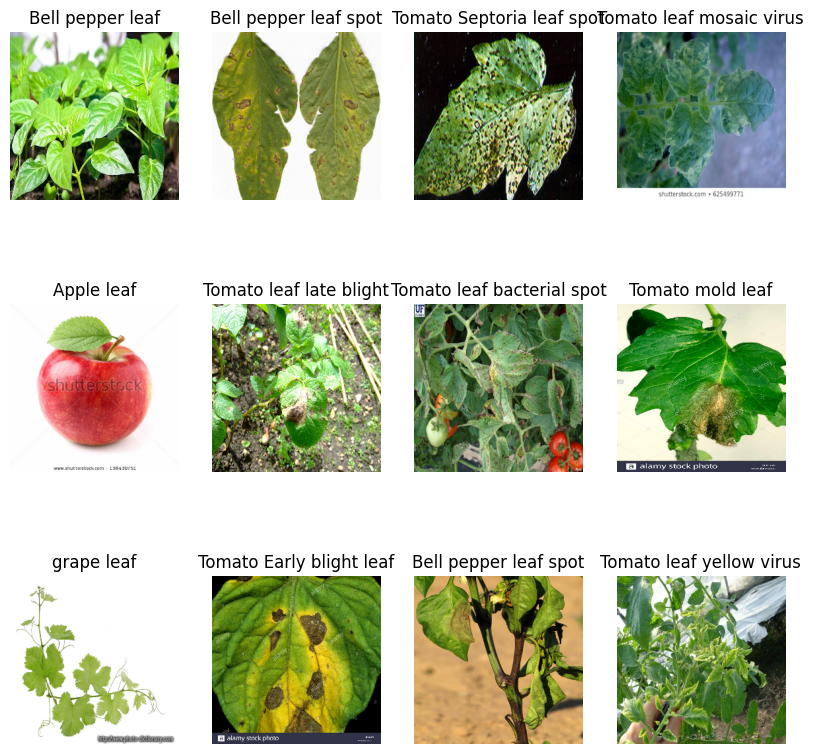

In [24]:
# Visualizing images with correct labels
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('int'))
        plt.axis('off')
        plt.title(class_names[labels[i].numpy()])  # Fixed class name access
plt.show()

In [25]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = tf.data.experimental.cardinality(ds).numpy()  # Get dataset size
    print("Dataset size:", ds_size)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Dataset size: 37


In [27]:
# Resizing and normalizing
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Fixed resizing
    layers.Rescaling(1./255),
])


In [28]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [29]:
n_classes = len(class_names)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [30]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,307 (723.86 KB)

 Trainable params: 185,307 (723.86 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Ensured labels are integers
    metrics=['accuracy']
)

In [32]:
# Train Model without showing validation data output
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,  # Suppresses all output
    epochs=EPOCHS
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.0356 - loss: 3.3035 - val_accuracy: 0.0208 - val_loss: 3.2950
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.0416 - loss: 3.2962 - val_accuracy: 0.0104 - val_loss: 3.2972
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.0393 - loss: 3.2957 - val_accuracy: 0.0659 - val_loss: 3.2936
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.0563 - loss: 3.2910 - val_accuracy: 0.0521 - val_loss: 3.2609
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.0455 - loss: 3.2483 - val_accuracy: 0.0833 - val_loss: 3.2642
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.0722 - loss: 3.2038 - val_accuracy: 0.0549 - val_loss: 3.1924
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.0624 - loss: 3.1774 - val_accuracy: 0.0625 - val_loss: 3.1748
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0792 - loss: 3.1341 - val_accuracy: 0.1667 - val_loss:

In [33]:
scores = model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9664 - loss: 0.1779


In [34]:
scores

[0.12984898686408997, 0.981249988079071]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 29}

In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [38]:
from PIL import Image
import numpy as np
image_path = "Plants\grape leaf\grape leaf 2.jpg" 
image = Image.open(image_path)
img_array = tf.keras.preprocessing.image.img_to_array(image)
img_array = tf.expand_dims(img_array, 0)

predictions=model.predict(img_array)

predictions

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\PMLS\AppData\Local\Temp\ipykernel_17268\302488405.py:3: SyntaxWarning: invalid escape sequence '\g'
  image_path = "Plants\grape leaf\grape leaf 2.jpg"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


array([[8.59638840e-06, 2.94794940e-04, 7.40245452e-12, 1.69404945e-03,
        1.25642850e-06, 4.59761673e-10, 2.56917446e-07, 3.62487435e-06,
        1.39399863e-11, 1.46579523e-05, 1.29494822e-07, 2.10395655e-12,
        2.01004298e-08, 2.60757806e-05, 1.15454095e-05, 2.07536004e-06,
        3.16590395e-12, 1.18671569e-05, 1.10311657e-06, 2.14961856e-05,
        7.64679555e-07, 2.91690776e-06, 1.88319129e-04, 7.63925957e-04,
        3.56156816e-05, 9.96909082e-01, 7.79559741e-06]], dtype=float32)

In [39]:
predicted_class = class_names[np.argmax(predictions)]
print (predicted_class)
print (np.max(predictions))

grape leaf
0.9969091


In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions)), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


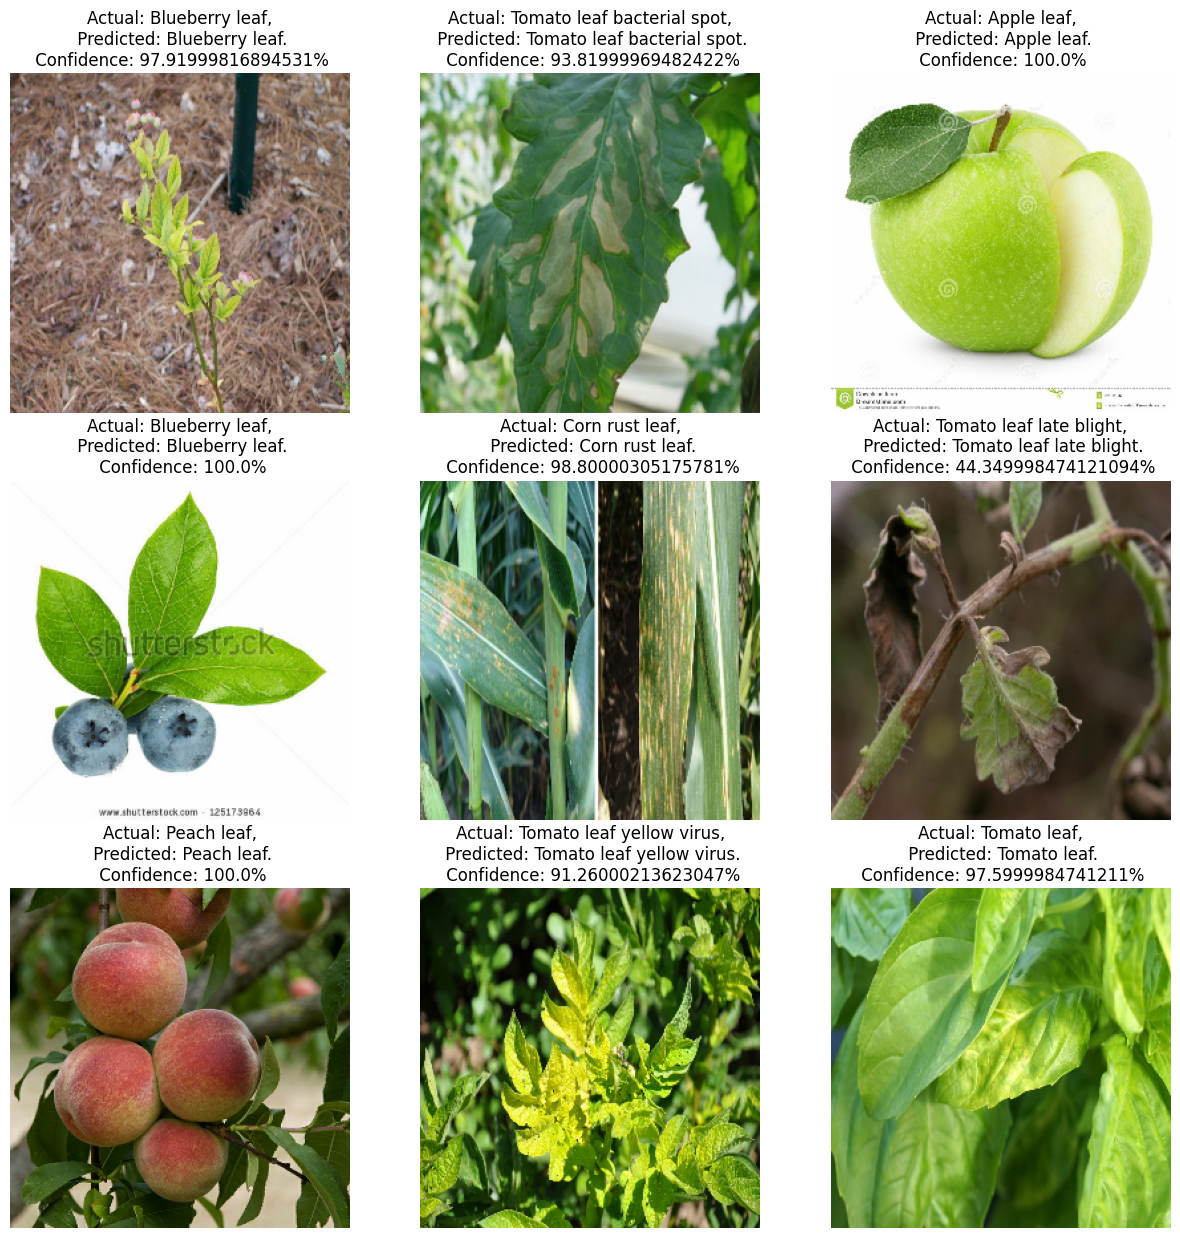

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("int"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
model.save("plant.h5")  
